In [4]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import scipy as sc
import pickle 
from rdkit import Chem

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import shuffle

import networkx as nx
from node2vec import Node2Vec

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
# seed the global RNG 
random.seed(SEED)
# seed the global NumPy RNG
np.random.seed(SEED)

##### Data preprocessing

In [11]:
def data_preprocessing(data, seed=SEED):
    """
    this function runs truncated SVD on document-term matrix of discrete/categorical features or PCA analysis on continuous features  
    :param x: a dataset of (n_samples, n_features)
    :param seed: seed for reproducibility 
    :return: dictionary with preprocessed data
    """
    # seed the global RNG 
    random.seed(seed)
    np.random.seed(seed)
    datatypes = ['int64', 'category']

    # check if input features are categorical/discrete
    if (data.dtypes.unique() in datatypes):
        print("Pipeline for discrete or categorical data")
        # get copy
        data = data.copy()
        # remove columns with all 0 values 
        data = data.loc[:, (data != 0).any(axis=0)]
       
        # instantiate the transformer
        tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True) 
        # fit and transform the count matrix to a normalized tf-idf representation
        tfidf_transformer.fit(data)
        tfidf_data = tfidf_transformer.transform(data)
        print("tf-idf representation computed")
      
        # search for the #components that explain at least 80% of variance
        n, var = 500, 0.80
        # compute vector space
        lsa = TruncatedSVD(n_components=n, random_state=seed)
        lsa.fit(tfidf_data)
        n_comp = 1
        while (lsa.explained_variance_ratio_[:n_comp].sum() <= var): 
            n_comp += 1
        print("number of principal components: ", n_comp)

        # perform dimensionality reduction using truncated SVD (LSA)
        lsa = TruncatedSVD(n_components=n_comp, random_state=seed)
        lsa_data = lsa.fit_transform(tfidf_data)
        print("explained variance: ", round(lsa.explained_variance_ratio_.sum(),2)*100,"%")

        # compute most important features
        feat = tfidf_transformer.get_feature_names_out()
        feat_dict = {}
        for i, comp in enumerate(lsa.components_):
            feat_comp = zip(feat, comp)
            # take top 10 descriptors for each component
            sorted_feat = sorted(feat_comp, key= lambda x:x[1], reverse=True)[:10]
            feat_dict.update({"Component "+str(i): [x[0] for x in sorted_feat]})   
        
        # prepare output dictionary 
        out_dict = {'annotation' : {'samples' : data.index, 'features' : data.columns}, 
                   'tfidf' : {'tfidf_transformer': tfidf_transformer, 'tfidf_data' : tfidf_data},
                   'lsa' : {'lsa_data' : lsa_data,  'features_components' : feat_dict}}

        
    else:
        print("Pipeline for continuous data")
        # get copy
        data = data.copy()
        # Replace infinite values with NaN
        data.replace([np.inf, -np.inf], np.nan, inplace=True)  
        # remove columns with all nan measures 
        data = data.dropna(axis=1, how='all')
        # replace NaN with mean value along the columns
        data = data.fillna(data.mean(axis=0), axis=0)   
        # remove columns with all 0 measures 
        data = data.loc[:, (data != 0).any(axis=0)]

        # standardize data before PCA
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
        print("data scaled")

        # search for the #components that explain at least 80% or 90% of variance
        if scaled_data.shape[1] > 500:
            var = 0.80
        else: 
            var = 0.90
        pca = PCA(n_components = var, random_state=seed)
        pca.fit(scaled_data)
        n_comp = pca.n_components_
        print("number of principal components: ", n_comp)

        # perform dimensionality reduction using PCA
        pca = PCA(n_components=n_comp, random_state=seed)
        pca_data = pca.fit_transform(scaled_data)
        print("Explained variance: ", round(pca.explained_variance_ratio_.sum(),2)*100,"%")

        # compute most important features
        feat = data.columns
        feat_dict = {}
        for i, comp in enumerate(pca.components_):
            feat_comp = zip(feat, comp)
            # take top 10 descriptors for each component
            sorted_feat = sorted(feat_comp, key= lambda x:x[1], reverse=True)[:10]
            feat_dict.update({"Component "+str(i): [x[0] for x in sorted_feat]})   

        out_dict = {'annotation' : {'samples' : data.index, 'features' : data.columns}, 
                    'pca': {'pca_data' : pca_data, 'features_components' : feat_dict}}

    return out_dict


##### Significance of similarity score

In [5]:
def metric_permutation(x, metric, thr=0.5, n_perm=999, seed=SEED): 
    """
    this function computes significance of the specified metric using permutation test
    :param x: a matrix of (n_samples, n_features)
    :param metric: metric name (cosine or euclidean)
    :param thr: acceptability threshold
    :param n_perm: number of permutations
    :param seed: seed for reproducibility 
    :return: dictionary with similarity matrix and corresponding p-value matrix
    """
    # seed the global RNG 
    random.seed(seed)
    np.random.seed(seed)

    # select metric to be computed
    if metric == 'cosine':
        metric_func = eval('cosine_similarity')
        # define sign function
        def sign_func(x,y): return x >= y
        # set replacement value 
        rpmv = -1e6
        # set plot title
        title = 'Cosine similarity'
    elif metric == 'euclidean':
        metric_func = eval('euclidean_distances')
        # define sign function
        def sign_func(x,y): return x <= y
        # set replacement value 
        rpmv = 1e6
        # set plot title 
        title = 'Euclidean distance'

    # compute pairwise metric of the row vectors of x
    pw_metric = metric_func(x, Y=None)
    # filter acceptable values 
    true_metric = np.where(sign_func(pw_metric, thr), pw_metric, rpmv)

    # plot heatmap
    plt.rcParams["figure.figsize"] = [7.50, 6.00]
    plt.rcParams["figure.autolayout"] = True
    sns.heatmap(pw_metric, yticklabels=False, xticklabels=False)
    plt.title(title)
    plt.show()
    
    # run permutation 
    sim_count = np.ones((x.shape[0], x.shape[0]))  
    for _ in range(n_perm):  
        null_mat = []
        # generate random dataset
        for i in range(0, x.shape[0]):
            # shuffle PC scores used as a new signature
            null_mat.append(shuffle(x[i]))    
        
        # compute null statistics distribution
        null_sim = metric_func(np.array(null_mat), Y=None)
        
        # count how many times the expected value is greater/lower or equal than the actual value
        sim_count += (np.array(sign_func(null_sim, true_metric))).astype(int)  
    
    # compute pvalue matrix
    pval_mat = (sim_count+1)/(n_perm+1) 
    
    # compute similarity from euclidean distance
    if metric == 'euclidean': pw_metric = 1 - ((pw_metric - pw_metric.min()) / (pw_metric.max() - pw_metric.min()))
    # prepare output dictionary
    sim_pval = {'similarity' : pw_metric, 'pvalue' : pval_mat}

    return sim_pval
    

In [13]:
# check if a matrix is symmetric
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

##### Network/Graph construction

In [14]:
def graph_construction(sample_names, sim_pval, alpha = 0.05, edge_attr='Similarity', seed=SEED):
    """
    this function constructs a graph from a similarity matrix and corresponding p-value matrix
    :param sample_names: a vector of sample names
    :param sim_pval: dictionary of similarity matrix and p-value matrix
    :param alpha: level of significance
    :param edge_attr: a string in ['Similarity', 'Pvalue', '-Log10Pvalue'] indicating the edge attribute
    :param seed: seed for reproducibility 
    :return: network of significant similarities and corresponding graph with the specified edge attribute
    """

    # seed the global RNG 
    random.seed(seed)
    np.random.seed(seed)

    # get upper triangular part of similarities and pvalues
    sim = sim_pval['similarity'][np.triu_indices(len(sample_names), k=1)]
    pval = sim_pval['pvalue'][np.triu_indices(len(sample_names), k=1)] 

    print("creating network") 
    # create a network with source/target/weight/pvalue of significant similarities
    net = pd.DataFrame({
        "Source"       : [s[0] for s in list(itertools.combinations(sample_names, 2))], 
        "Target"       : [t[1] for t in list(itertools.combinations(sample_names, 2))],
        "Similarity"   : sim,
        "Pvalue"       : pval,
        "-Log10Pvalue" : -np.log10(pval)})

    # take significant similarities
    net = net[net['Pvalue'] < alpha]    
        
    print("constructing graph")
    # construct output graph
    graph = nx.from_pandas_edgelist(
        net,
        source='Source',
        target='Target',
        edge_attr=edge_attr)

    print("#nodes: ", graph.number_of_nodes())
    print("#edges: ", graph.number_of_edges())


    return net, graph 

##### Graph/Node embedding

In [15]:
def graph_embedding(g, filename, dim, seed=SEED):
    """
    this function runs node2vec algorithm on a precomputed graph 
    :param g: input weighted graph
    :param filename: name of file storing embedding model 
    :param dim: embedding dimension
    :param seed: seed for reproducibility 
    :return: node2vec model and embeddings 
    """

    # seed the global RNG 
    random.seed(seed)
    np.random.seed(seed)

    # run node2vec
    node2vec = Node2Vec(g, dimensions=dim, walk_length=32, num_walks=100, weight_key='weight', workers=1, seed=seed) 
    # learn embeddings 
    model = node2vec.fit(window=10, min_count=1)

    # store embedding for each node 
    embeddings = []
    for id in model.wv.key_to_index.keys():
        embeddings.append({'id':int(id), 'embedding': [float(x) for x in list(model.wv[id])]})

    # save model for later use
    model.save(filename)
    
    return model, embeddings 

#### Extract single elements

In [28]:
# load molecules table 
path = '../Flask/psql_db/Tables'
molecules = pd.read_csv(path + '/MoleculesTable.csv', encoding='latin1')
molecules.head()

,Chemical_Name,CID,CAS,InChIKey,Canonical_SMILES,Molecular_Formula,Atoms,Molecule_Type
0,(1-methylpropyl)benzene,8680,135-98-8,ZJMWRROPUADPEA-UHFFFAOYSA-N,CCC(C)C1=CC=CC=C1,C10H14,[C],organic
1,(2-methylbutyl)cyclohexane,143127,54105-77-0,DDQXBDLAGHZBMP-UHFFFAOYSA-N,CCC(C)CC1CCCCC1,C11H22,[C],organic
2,(2-methylpropyl)benzene,10870,538-93-2,KXUHSQYYJYAXGZ-UHFFFAOYSA-N,CC(C)CC1=CC=CC=C1,C10H14,[C],organic
3,"1,1,1-trichloroethane",6278,71-55-6,UOCLXMDMGBRAIB-UHFFFAOYSA-N,CC(Cl)(Cl)Cl,C2H3Cl3,"[C, Cl]",organic
4,"1,1,2,2-tetrachloroethane",6591,79-34-5,QPFMBZIOSGYJDE-UHFFFAOYSA-N,C(C(Cl)Cl)(Cl)Cl,C2H2Cl4,"[C, Cl]",organic


In [27]:
def composition(smiles):
    """
    this function gets the composition of an RDKit molecule: atomic counts, including hydrogen atoms and formal charge, 
    and returns only single elements
    :param smiles: list of molecular SMILES strings
    :return: list of single elements 
    """

    single_elem = []
    for s in smiles:
        # get molecule
        mol = Chem.MolFromSmiles(s)
        # add hydrogens
        mol = Chem.AddHs(mol) 
        # check if single atom 
        if mol.GetNumAtoms() == 1:
            # get formal charge
            charge = Chem.GetFormalCharge(mol)
            # manage charge (Na+, Cl-, K+, Cr+6 or Mg+2)
            if charge != 0:
                if  charge == 1:
                    charge = "+"
                elif charge == -1:
                    charge = "-"
                else:
                    charge = "+"+str(charge)
                single_elem.append([atom.GetSymbol()+charge for atom in mol.GetAtoms()][0])
            else:
                single_elem.append([atom.GetSymbol() for atom in mol.GetAtoms()][0])
        elif mol.GetNumAtoms() == 2:
            # manage 2 identical atoms (Br2, Cl2 or F2)
            if mol.GetAtoms()[0].GetSymbol() == mol.GetAtoms()[1].GetSymbol():
                single_elem.append([atom.GetSymbol()+"2" for atom in mol.GetAtoms()][0])
        
    
    return single_elem

In [29]:
# output single elements
single_elem = composition(molecules.Canonical_SMILES)
print(single_elem, " Num:", len(np.unique(single_elem)))

['Al', 'Sb', 'As', 'Ba', 'Br2', 'Cd', 'Ca', 'Cl-', 'Cl2', 'Cr', 'Co', 'Cu', 'C', 'Ga', 'Au', 'In', 'Fe', 'La', 'Pb', 'Mg', 'Mn', 'Hg', 'Mo', 'Ni', 'Pd', 'P', 'K', 'Rb', 'Se', 'Si', 'Ag', 'Na', 'Sr', 'S', 'Tl', 'Sn', 'Ti', 'U', 'V', 'Y', 'Zn', 'Zr', 'Na+', 'Cl', 'Br', 'Be', 'Te', 'Dy', 'Li', 'Nd', 'Nb', 'Pr', 'Sm', 'Sc', 'Ta', 'Tb', 'Th', 'W', 'B', 'Ce', 'Cs', 'Eu', 'Gd', 'Ge', 'Hf', 'Ho', 'Yb', 'Bi', 'I', 'F2', 'K+', 'Pa', 'Er', 'Pt', 'Cr+6', 'Ir', 'Mg+2', 'Lu', 'Ru', 'Rh']  Num: 80


In [30]:
# return associated CID
elem_cid = molecules.CID[np.where(np.in1d(molecules.Molecular_Formula, np.array(single_elem)))[0]]
elem_cid

255     5359268
258     5354495
259     5359596
261     5355457
268       24408
         ...   
1346      23924
1416        888
1482      23929
1645      23950
1646      23948
Name: CID, Length: 77, dtype: int64

##### Application to Fingerprints Bits & Counts

Fingerprint weightings are:
- Binary: fingerprint does or doesn’t occur in molecule
- Counts: number of times fingerprint occurs in molecule


In [23]:
# read data
fingerprint_data = pd.read_csv(path + '/FingerprintsTable.csv')
print(fingerprint_data.index, fingerprint_data.columns)

Int64Index([  8680, 143127,  10870,  69848,  12993, 164514,  86240,  13129,
             67884,   6278,
            ...
             26042,  24193,  23963,  23964,  23989,  23990,  23992,  23993,
             23994,  23995],
           dtype='int64', length=1826) Index(['FP1', 'FP2', 'FP3', 'FP4', 'FP5', 'FP6', 'FP7', 'FP8', 'FP9', 'FP10',
       ...
       'APC2D10_I_I', 'APC2D10_I_B', 'APC2D10_I_Si', 'APC2D10_I_X',
       'APC2D10_B_B', 'APC2D10_B_Si', 'APC2D10_B_X', 'APC2D10_Si_Si',
       'APC2D10_Si_X', 'APC2D10_X_X'],
      dtype='object', length=16092)


In [16]:
# remove single elements CID from FP data
fingerprint_data = fingerprint_data.loc[~fingerprint_data.index.isin(elem_cid)]
fingerprint_data 

,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,FP10,...,APC2D10_I_I,APC2D10_I_B,APC2D10_I_Si,APC2D10_I_X,APC2D10_B_B,APC2D10_B_Si,APC2D10_B_X,APC2D10_Si_Si,APC2D10_Si_X,APC2D10_X_X
8680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143127,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24841,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26042,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### FP bits

In [22]:
# remove all columns between column index 10145 to end (i.e., fingerprint counts)
fingerprint_bits = fingerprint_data.drop(fingerprint_data.iloc[:, 10145:fingerprint_data.shape[1]], axis=1)
len(fingerprint_bits.columns)

10145

In [18]:
# run preprocessing
fp_bits_preprocess = data_preprocessing(fingerprint_bits)
fp_bits_preprocess 

Pipeline for discrete or categorical data
tf-idf representation computed
number of principal components:  120
explained variance:  80.0 %


{'annotation': {'samples': Int64Index([   8680,  143127,   10870,   69848,   12993,  164514,   86240,
                13129,   67884,    6278,
              ...
                 1117,    1119,   24682, 4685067,   14778,   24841,   14781,
                11430,   26042,   24193],
             dtype='int64', length=1750),
  'features': Index(['FP1', 'FP2', 'FP3', 'FP4', 'FP5', 'FP6', 'FP7', 'FP8', 'FP9', 'FP10',
         ...
         'AD2D714', 'AD2D715', 'AD2D726', 'AD2D729', 'AD2D735', 'AD2D760',
         'AD2D765', 'AD2D766', 'AD2D770', 'AD2D780'],
        dtype='object', length=5218)},
 'tfidf': {'tfidf_transformer': TfidfTransformer(),
  'tfidf_data': <1750x5218 sparse matrix of type '<class 'numpy.float64'>'
  	with 467820 stored elements in Compressed Sparse Row format>},
 'lsa': {'lsa_data': array([[ 4.46150378e-01,  4.65599796e-01, -2.30471042e-01, ...,
           1.78108040e-02, -4.14571861e-03,  3.34084720e-02],
         [ 7.61418679e-01, -2.97931919e-01, -2.92913529e-01, ...,

In [19]:
# print idf values of fingerprints sorted ascending
df_idf = pd.DataFrame(fp_bits_preprocess['tfidf']['tfidf_transformer'].idf_, index=fp_bits_preprocess['annotation']['features'], columns=["idf_weights"]).sort_values(by=['idf_weights'])
df_idf

,idf_weights
GraphFP742,1.009756
FP742,1.009756
FP743,1.012066
GraphFP743,1.012066
SubFP307,1.013222
...,...
KRFP1449,7.774795
KRFP2870,7.774795
KRFP2877,7.774795
KRFP4498,7.774795


In [20]:
# which are the most relevant substructures of Carbon Monoxide (CID 281, index 1719)? 
CO_tf_idf = pd.DataFrame(fp_bits_preprocess['tfidf']['tfidf_data'][1719].T.todense(), 
                        index=fp_bits_preprocess['annotation']['features'], columns=["tfidf"])

# print the sorted values
CO_tf_idf.sort_values(by=['tfidf'], ascending=False).head(15)

# AP2D3	             Presence of C-O at topological distance 1
# KR4331	         O  
# PubchemFP286       Simple atom pairs C-O
# PubchemFP18        >= 1 O     

,tfidf
SubFP22,0.520475
ExtFP837,0.453131
FP1006,0.326514
SubFP298,0.270500
SubFP297,0.222365
SubFP299,0.222365
SubFP296,0.210087
MACCSFP49,0.210087
AD2D3,0.129343
PubchemFP286,0.129343


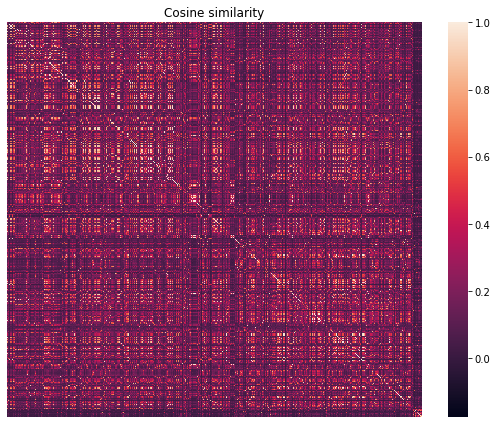

In [37]:
# run permutation function on the reduced feature matrix with acceptability threshold of 0.6 
sim_pval_fd = metric_permutation(fp_bits_preprocess['lsa']['lsa_data'], 'cosine', thr=0.6)

In [38]:
# significant pvalues (alpha = 0.05)
print("pval 0.05:", np.count_nonzero(sim_pval_fd['pvalue'] < 0.05)/2, " pval 0.01:", np.count_nonzero(sim_pval_fd['pvalue'] < 0.01)/2)

pval 0.05: 76005.0  pval 0.01: 75983.0


In [35]:
# check if pvalue matrix is symmetric
check_symmetric(sim_pval_fd['pvalue'])

True

In [40]:
# add similarities to preprocessed object
fp_bits_preprocess['metric'] = {'similarity_matrix' : sim_pval_fd['similarity'], 'pvalue_matrix' : sim_pval_fd['pvalue']}

In [41]:
# construct network and graph of significant similarities
N1, G1 = graph_construction(fp_bits_preprocess['annotation']['samples'], sim_pval_fd, alpha=0.05)

creating network
constructing graph
#nodes:  1749
#edges:  75978


In [42]:
# add network and graph to preprocessed object
fp_bits_preprocess['net'] = {'network' : N1, 'graph' : G1}

In [43]:
# which is the smallest similarity value?
fp_bits_preprocess['net']['network']['Similarity'].min()

0.6000042372844766

In [44]:
# save object 
filename = '../Preprocessed_data/fp_bits.obj'
filehandler = open(filename, 'wb') 
pickle.dump(fp_bits_preprocess, filehandler)

In [47]:
# construct embedding model and save it
G1_model, G1_embeds = graph_embedding(G1, '../Embedding_models/FPBitsEmbedding', dim=36)

Computing transition probabilities:   0%|          | 0/1749 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


#### FP counts

In [36]:
# keep only counts from FP data: SubFPC, KRFPC, APC2D
fingerprint_counts = fingerprint_data.iloc[:, 10145:fingerprint_data.shape[1]]
fingerprint_counts

,SubFPC1,SubFPC2,SubFPC3,SubFPC4,SubFPC5,SubFPC6,SubFPC7,SubFPC8,SubFPC9,SubFPC10,...,APC2D10_I_I,APC2D10_I_B,APC2D10_I_Si,APC2D10_I_X,APC2D10_B_B,APC2D10_B_Si,APC2D10_B_X,APC2D10_Si_Si,APC2D10_Si_X,APC2D10_X_X
8680,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143127,2,7,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10870,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69848,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12993,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24841,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26042,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# show columns
fingerprint_counts.columns

Index(['SubFPC1', 'SubFPC2', 'SubFPC3', 'SubFPC4', 'SubFPC5', 'SubFPC6',
       'SubFPC7', 'SubFPC8', 'SubFPC9', 'SubFPC10',
       ...
       'APC2D10_I_I', 'APC2D10_I_B', 'APC2D10_I_Si', 'APC2D10_I_X',
       'APC2D10_B_B', 'APC2D10_B_Si', 'APC2D10_B_X', 'APC2D10_Si_Si',
       'APC2D10_Si_X', 'APC2D10_X_X'],
      dtype='object', length=5947)

In [50]:
# run preprocessing
fp_counts_preprocess = data_preprocessing(fingerprint_counts)
fp_counts_preprocess

Pipeline for discrete or categorical data
tf-idf representation computed
number of principal components:  46
explained variance:  80.0 %


{'annotation': {'samples': Int64Index([   8680,  143127,   10870,   69848,   12993,  164514,   86240,
                13129,   67884,    6278,
              ...
                 1117,    1119,   24682, 4685067,   14778,   24841,   14781,
                11430,   26042,   24193],
             dtype='int64', length=1750),
  'features': Index(['SubFPC1', 'SubFPC2', 'SubFPC3', 'SubFPC4', 'SubFPC5', 'SubFPC6',
         'SubFPC7', 'SubFPC8', 'SubFPC9', 'SubFPC10',
         ...
         'APC2D10_C_X', 'APC2D10_N_N', 'APC2D10_O_O', 'APC2D10_O_F',
         'APC2D10_O_X', 'APC2D10_Cl_Cl', 'APC2D10_Cl_X', 'APC2D10_Br_Br',
         'APC2D10_Br_X', 'APC2D10_X_X'],
        dtype='object', length=1515)},
 'tfidf': {'tfidf_transformer': TfidfTransformer(),
  'tfidf_data': <1750x1515 sparse matrix of type '<class 'numpy.float64'>'
  	with 76585 stored elements in Compressed Sparse Row format>},
 'lsa': {'lsa_data': array([[ 8.12594735e-01,  3.60701844e-01, -1.29693415e-02, ...,
          -9.78689333e-0

In [51]:
# print idf values of fingerprints sorted ascending
df_idf = pd.DataFrame(fp_counts_preprocess['tfidf']['tfidf_transformer'].idf_, index=fp_counts_preprocess['annotation']['features'], columns=["idf_weights"]).sort_values(by=['idf_weights'])
df_idf

,idf_weights
SubFPC307,1.013222
APC2D1_C_C,1.055782
APC2D2_C_C,1.071607
KRFPC2975,1.111662
SubFPC300,1.121287
...,...
KRFPC4258,7.774795
KRFPC4257,7.774795
KRFPC1759,7.774795
KRFPC4328,7.774795


In [52]:
# which are the most relevant substructures of Carbon Monoxide (CID 281, index 1719)? 
CO_tf_idf = pd.DataFrame(fp_counts_preprocess['tfidf']['tfidf_data'][1719].T.todense(), 
                        index=fp_counts_preprocess['annotation']['features'], columns=["tfidf"])
# print the sorted values
CO_tf_idf.sort_values(by=['tfidf'], ascending=False).head(10)

,tfidf
SubFPC22,0.634941
SubFPC296,0.512581
SubFPC298,0.329989
SubFPC299,0.271269
SubFPC297,0.271269
APC2D1_C_O,0.157789
KRFPC4331,0.151756
SubFPC295,0.142065
KRFPC2975,0.099672
KRFPC4164,0.000000


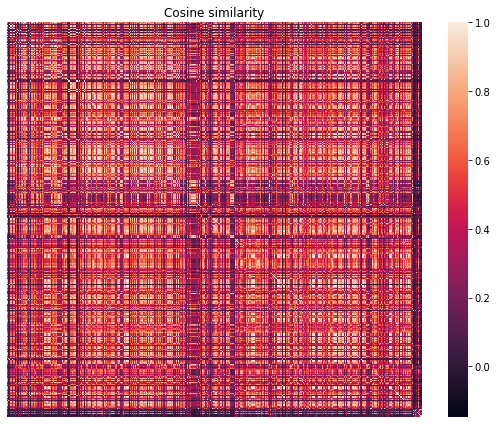

In [53]:
# run permutation function on the reduced feature matrix with acceptability threshold of 0.6 
sim_pval_fc = metric_permutation(fp_counts_preprocess['lsa']['lsa_data'], 'cosine', thr=0.6)

In [54]:
# significant pvalues (alpha = 0.01)
print("pval 0.05:", np.count_nonzero(sim_pval_fc['pvalue'] < 0.05)/2, " pval 0.01:", np.count_nonzero(sim_pval_fc['pvalue'] < 0.01)/2)

pval 0.05: 507656.5  pval 0.01: 326950.5


In [55]:
# check if pvalue matrix is symmetric
check_symmetric(sim_pval_fc['pvalue'])

True

In [56]:
# add similarities to preprocessed object
fp_counts_preprocess['metric'] = {'similarity_matrix' : sim_pval_fc['similarity'], 'pvalue_matrix' : sim_pval_fc['pvalue']}

In [57]:
# construct network and graph of significant similarities
N2, G2 = graph_construction(fp_counts_preprocess['annotation']['samples'], sim_pval_fc, alpha=0.01)

creating network
constructing graph
#nodes:  1750
#edges:  326949


In [58]:
# add network and graph to preprocessed object
fp_counts_preprocess['net'] = {'network' : N2, 'graph' : G2}

In [59]:
# which is the smallest similarity value?
fp_counts_preprocess['net']['network']['Similarity'].min()

0.6000022196535392

In [60]:
# save object 
filename = '../Preprocessed_data/fp_counts.obj'
filehandler = open(filename, 'wb') 
pickle.dump(fp_counts_preprocess, filehandler)

In [61]:
# construct embedding model
G2_model, G2_embeds = graph_embedding(G2, '../Embedding_models/FPCountsEmbedding', dim=36)

Computing transition probabilities:   0%|          | 0/1750 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [03:26<00:00,  2.06s/it]


#### Molecular descriptors

In [79]:
# load molecular descriptors data
molecular_descriptors = pd.read_csv(path + '/MolecularDescriptorsTable.csv', low_memory=False).astype('float64')
print(molecular_descriptors.columns, molecular_descriptors.dtypes.unique())

Index(['nAcid', 'ALogP', 'ALogp2', 'AMR', 'apol', 'naAromAtom', 'nAromBond',
       'nAtom', 'nHeavyAtom', 'nH',
       ...
       'P1s', 'P2s', 'E1s', 'E2s', 'E3s', 'Ts', 'As', 'Vs', 'Ks', 'Ds'],
      dtype='object', length=1875) [dtype('float64')]


In [50]:
# remove single elements CID 
molecular_desc = molecular_descriptors.loc[~molecular_descriptors.index.isin(elem_cid)]
molecular_desc.index 

Int64Index([   8680,  143127,   10870,   69848,   12993,  164514,   86240,
              13129,   67884,    6278,
            ...
               1117,    1119,   24682, 4685067,   14778,   24841,   14781,
              11430,   26042,   24193],
           dtype='int64', length=1750)

In [255]:
# run preprocessing 
mol_desc_preprocess = data_preprocessing(molecular_desc)
mol_desc_preprocess

Pipeline for continuous data
data scaled
number of principal components:  48
Explained variance:  80.0 %


{'annotation': {'samples': Int64Index([   8680,  143127,   10870,   69848,   12993,  164514,   86240,
                13129,   67884,    6278,
              ...
                 1117,    1119,   24682, 4685067,   14778,   24841,   14781,
                11430,   26042,   24193],
             dtype='int64', length=1750),
  'features': Index(['nAcid', 'ALogP', 'ALogp2', 'AMR', 'apol', 'naAromAtom', 'nAromBond',
         'nAtom', 'nHeavyAtom', 'nH',
         ...
         'P1s', 'P2s', 'E1s', 'E2s', 'E3s', 'Ts', 'As', 'Vs', 'Ks', 'Ds'],
        dtype='object', length=1675)},
 'pca': {'pca_data': array([[ -7.05043105,   4.41111069,  -8.69597704, ...,   1.06360682,
            1.51658494,   0.22010407],
         [  0.58941326,  -2.41669609, -11.55908192, ...,  -0.17072875,
           -0.07989102,  -0.16213433],
         [ -6.67228085,   3.56642181,  -8.64308698, ...,   0.13109836,
            1.18292608,   0.89302626],
         ...,
         [ -9.13388871,  -6.88906247,  15.71301314, ...,   

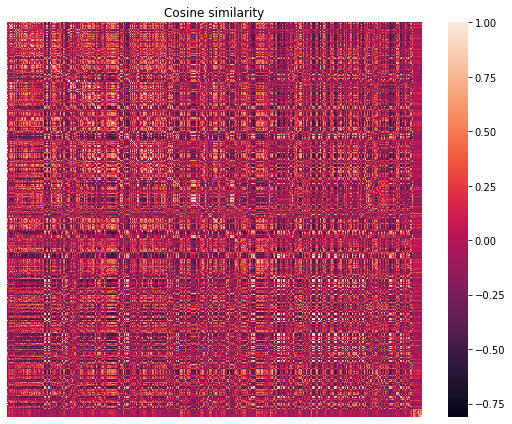

In [66]:
# run permutation function on the reduced feature matrix with acceptability threshold of 0.6 
sim_pval_md = metric_permutation(mol_desc_preprocess['pca']['pca_data'], 'cosine', thr=0.6)

In [67]:
# significant pvalues (alpha = 0.05)
print("pval 0.05:", np.count_nonzero(sim_pval_md['pvalue'] < 0.05)/2, " pval 0.01:", np.count_nonzero(sim_pval_md['pvalue'] < 0.01)/2) 

pval 0.05: 85340.0  pval 0.01: 82884.5


In [68]:
# check if pvalue matrix is symmetric
check_symmetric(sim_pval_md['pvalue'])

True

In [69]:
# add similarities to preprocessed object
mol_desc_preprocess['metric'] = {'similarity_matrix' : sim_pval_md['similarity'], 'pvalue_matrix' : sim_pval_md['pvalue']}

In [70]:
# construct network and graph of significant similarities
N3, G3 = graph_construction(mol_desc_preprocess['annotation']['samples'], sim_pval_md, alpha=0.05)

creating network
constructing graph
#nodes:  1747
#edges:  85320


In [71]:
# add network and graph to preprocessed object
mol_desc_preprocess['net'] = {'network' : N3, 'graph' : G3}

In [72]:
# which is the smallest similarity value?
mol_desc_preprocess['net']['network']['Similarity'].min()

0.6000002818104659

In [73]:
# save object 
filename = '../Preprocessed_data/mol_desc.obj'
filehandler = open(filename, 'wb') 
pickle.dump(mol_desc_preprocess, filehandler)

In [74]:
# construct embedding model
G3_model, G3_embeds = graph_embedding(G3, '../Embedding_models/MolDescEmbedding', dim=36)

Computing transition probabilities:   0%|          | 0/1747 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


In [75]:
# return similar molecules to (1-Methylpropyl)benzene 
molecules[['CID', 'Chemical_Name', 'Molecular_Formula', 'Canonical_SMILES']][molecules['CID'].isin([(int(x)) for x in list(zip(*G3_model.wv.most_similar('8680', topn=10)))[0]])]

,CID,Chemical_Name,Molecular_Formula,Canonical_SMILES
35,13629,"1,2-dimethyl-4-ethylbenzene",C10H14,CCC1=CC(=C(C=C1)C)C
49,13403,"1,3-dimethyl-4-ethylbenzene",C10H14,CCC1=C(C=C(C=C1)C)C
64,519210,1-ethyl-2-npropylbenzene,C11H16,CCCC1=CC=CC=C1CC
75,14091,1-Methyl-2-n-propylbenzene,C10H14,CCCC1=CC=CC=C1C
223,14527,3-phenylpentane,C11H16,CCC(CC)C1=CC=CC=C1
793,520475,"p-xylene, 2-propyl-",C11H16,CCCC1=C(C=CC(=C1)C)C
803,28812,"1-ethyl-2,4,5-trimethyl benzene",C11H16,CCC1=C(C=C(C(=C1)C)C)C
804,33047,"Toluene, 3,4-diethyl-",C11H16,CCC1=C(C=C(C=C1)C)CC
809,528288,"1,2-dimethyl-3-propyl benzene",C11H16,CCCC1=CC=CC(=C1C)C
812,519358,"1,3-dimethyl-2-propyl benzene",C11H16,CCCC1=C(C=CC=C1C)C


##### Analyse molecular descriptors of single elements

In [52]:
# take descriptors of single elements (by CID) 
mol_desc_elem = molecular_descriptors.loc[molecular_descriptors.index.isin(elem_cid)]
mol_desc_elem.head()

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,P1s,P2s,E1s,E2s,E3s,Ts,As,Vs,Ks,Ds
5359268,0.0,NaN,NaN,NaN,6.800000,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5460467,0.0,NaN,NaN,NaN,5.600000,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5462311,0.0,0.0000,0.000000,0.0000,5.030379,0.0,0.0,4.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5360770,0.0,0.0000,0.000000,0.0000,3.716793,0.0,0.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24408,0.0,1.7776,3.159862,17.1982,6.100000,0.0,0.0,2.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [300]:
# run preprocessing 
mol_desc_preprocess_elem = data_preprocessing(mol_desc_elem)
mol_desc_preprocess_elem

Pipeline for continuous data
data scaled
number of principal components:  9
Explained variance:  92.0 %


{'annotation': {'samples': Int64Index([5359268, 5460467, 5462311, 5360770,   24408,     312, 5360523,
                24526,   24524, 3028194,     888, 5462224, 5462309, 6326970,
              5461123,     923, 5360545, 5354495, 5359596, 5355457, 5359367,
                23973, 5460341,   23974, 5354618,   29131,   23976,  104730,
                23978,   23912,   23980,   23981,   23982, 5360835, 6326954,
                23985,   23986,   23988, 5359967,   23924,   23925,   23926,
              5352425,   23929,   23930,   23931,   23932,   23934,     935,
                23936,   23938,   23939,     813, 5462222,   23942,   23948,
              5357696,   23950,   23951,   23952,   23954, 5359327,   23956,
              6327182,   23958, 5359464,   23960, 5352426,   23963,   23964,
                23989,   23990,   23992,   23993,   23994,   23995],
             dtype='int64'),
  'features': Index(['ALogP', 'ALogp2', 'AMR', 'apol', 'nAtom', 'nHeavyAtom', 'nH', 'nB',
         'nP', 'n

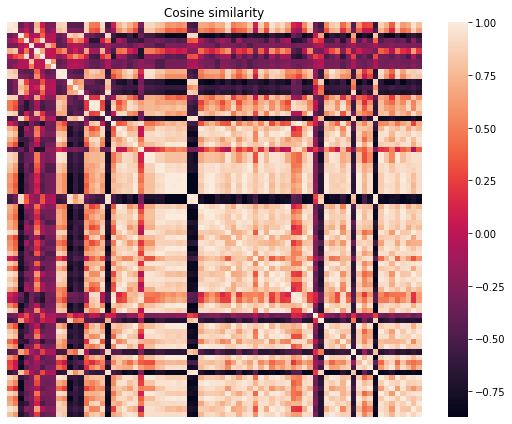

In [301]:
# run permutation function on the reduced feature matrix with acceptability threshold of 0.6
sim_pval_md_elem = metric_permutation(mol_desc_preprocess_elem['pca']['pca_data'], 'cosine', thr=0.6)

In [302]:
# significant pvalues (alpha = 0.05)
print("pval 0.05:", np.count_nonzero(sim_pval_md_elem['pvalue'] < 0.05)/2, " pval 0.01:", np.count_nonzero(sim_pval_md_elem['pvalue'] < 0.01)/2) 

pval 0.05: 1287.0  pval 0.01: 769.0


In [73]:
# check if pvalue matrix is symmetric
check_symmetric(sim_pval_md_elem['pvalue'])

True

In [303]:
# add similarities to preprocessed object
mol_desc_preprocess_elem['metric'] = {'similarity_matrix' : sim_pval_md_elem['similarity'], 'pvalue_matrix' : sim_pval_md_elem['pvalue']}

In [304]:
# construct network and graph of significant similarities
N3_elem, G3_elem = graph_construction(mol_desc_preprocess_elem['annotation']['samples'], sim_pval_md_elem, alpha=0.05)

creating network
constructing graph
#nodes:  74
#edges:  1285


In [305]:
# add network and graph to preprocessed object
mol_desc_preprocess_elem['net'] = {'network' : N3_elem, 'graph' : G3_elem}

In [306]:
# which is the smallest similarity value?
mol_desc_preprocess_elem['net']['network']['Similarity'].min()

0.6009233660894935

In [307]:
# save object 
filename = '../Preprocessed_data/mol_desc_elem.obj'
filehandler = open(filename, 'wb') 
pickle.dump(mol_desc_preprocess_elem, filehandler)

In [308]:
# construct embedding model
G3_elem_model, G3_elem_embeds = graph_embedding(G3_elem, '../Embedding_models/MolDescElemEmbedding', dim=36)

Computing transition probabilities:   0%|          | 0/74 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 78.21it/s]


##### Quantum properties

In [80]:
# load quantum properties data
quantum_properties = pd.read_csv(path + '/QuantumPropertiesTable.csv', index_col = 0)
quantum_properties

,Chemical_Name,Spin_multiplicity,QM_Basis,No_canonical_orbitals,Geometry_convergence_category,Gas_Phase_Energy,Final_Energy,HOMO,LUMO,Polarizability,...,tautomer_probability,Ionization_Penalty,Ionization_Penalty_Charging,Ionization_Penalty_Neutral,State_Penalty,Charging_Adjusted_Penalty,Tot_Q,Tot_abs_Q,Energy,Chemistry_Notes
Molecule_CID,,,,,,,,,,,,,,,,,,,,,
528971,1-Heptacosene,1,cc-pvtz(-f),1098.0,3.0,-1061.858633,-1061.858633,-0.254592,-0.029015,336.426187,...,1.0,0.0000,0.0,0.0000,0.0000,0.000000,0.0,0.0,11.398261,NaN
13387,1-Methyl-2-pyrrolidinone,1,cc-pvtz(-f),241.0,0.0,-326.065734,-326.065734,-0.241367,0.016984,67.354711,...,1.0,0.0000,0.0,0.0000,0.0000,0.000000,0.0,0.0,-7.963149,NaN
7304,1-Methylpyrrole,1,cc-pvtz(-f),200.0,0.0,-249.567655,-249.567655,-0.211266,0.025195,61.791634,...,1.0,0.0000,0.0,0.0000,0.0000,0.000000,0.0,0.0,0.621472,NaN
7903,1-Nitropropane,1,cc-pvtz(-f),201.0,0.0,-323.767047,-323.767047,-0.307382,-0.083080,52.471290,...,NaN,0.0003,0.0,0.0003,0.0002,0.000212,0.0,2.0,1.488319,NaN
181154,1-Tricosene,1,cc-pvtz(-f),936.0,4.0,-904.540655,-904.540655,-0.239421,0.026033,285.315953,...,1.0,0.0000,0.0,0.0000,0.0000,0.000000,0.0,0.0,9.535517,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23990,Vanadium,2,lacv3p**,31.0,NaN,-71.111487,-71.111487,-0.191222,-0.171330,83.027976,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23992,Ytterbium,1,csdz**,40.0,NaN,-247.528609,-247.528609,-0.084072,0.085584,59.451565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23993,Yttrium,2,lacv3p**,31.0,NaN,-37.852668,-37.852668,-0.147972,-0.067699,149.244164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# drop unnecessary columns 
cols = quantum_properties.columns[28:len(quantum_properties.columns)].tolist()
cols.extend(['Chemical_Name', 'Spin_multiplicity', 'QM_Basis', 'No_canonical_orbitals', 'Geometry_convergence_category'])
quantum_properties = quantum_properties.drop(cols, axis=1)
quantum_properties.head(10)

,Gas_Phase_Energy,Final_Energy,HOMO,LUMO,Polarizability,QM_Dipole,QM_Dipole_X,QM_Dipole_Y,QM_Dipole_Z,Lowest_Frequency,...,Zero_Point_Energy,Entropy,Enthalpy,Free_Energy,Internal_Energy,Heat_Capacity,ln_Q,Total_Internal_Energy,Total_Enthalpy,Total_Free_Energy
Molecule_CID,,,,,,,,,,,,,,,,,,,,,
528971,-1061.858633,-1061.858633,-0.254592,-0.029015,336.426187,0.429655,-0.401884,-0.138425,0.062701,18.687569,...,479.176185,199.756121,21.186870,-38.370418,20.594384,126.272993,64.761774,-1061.062198,-1061.061253,-1061.156164
13387,-326.065734,-326.065734,-0.241367,0.016984,67.354711,3.903869,0.687301,-3.839535,-0.160573,172.624905,...,86.749557,79.817331,4.755402,-19.042135,4.162916,24.604924,32.139407,-325.920856,-325.919911,-325.957835
7304,-249.567655,-249.567655,-0.211266,0.025195,61.791634,2.134364,-2.134232,0.023727,0.000015,151.146979,...,68.863932,73.249078,3.950657,-17.888556,3.358171,19.831906,30.192390,-249.452561,-249.451617,-249.486420
7903,-323.767047,-323.767047,-0.307382,-0.083080,52.471290,3.854956,-1.647850,3.485007,-0.000409,90.441722,...,67.167166,79.321331,4.601080,-19.048575,4.008594,21.781848,32.150276,-323.653621,-323.652677,-323.690365
181154,-904.540655,-904.540655,-0.239421,0.026033,285.315953,0.502935,-0.044755,-0.078367,0.494771,21.747146,...,407.549523,179.191759,18.127267,-35.298756,17.534781,107.382564,59.577409,-903.863240,-903.862296,-903.947436
8247,-495.765430,-495.765430,-0.228660,-0.022677,108.727297,2.995951,-2.061774,-0.006773,2.173653,61.111779,...,107.522532,96.501948,6.733967,-22.038089,6.141482,38.075722,37.195991,-495.584294,-495.583350,-495.629201
5897,-709.683759,-709.683759,-0.194993,-0.029155,195.912627,3.859490,-1.804832,3.209853,-1.155457,54.929655,...,151.540379,112.220921,8.879124,-24.579543,8.286639,54.322389,41.485470,-709.429059,-709.428115,-709.481434
79123,-438.310724,-438.310724,-0.314270,-0.068636,70.457442,3.506168,-2.269365,-2.189100,-1.533309,98.684316,...,87.095901,89.404420,5.900512,-20.755416,5.308026,30.656119,35.031090,-438.163469,-438.162524,-438.205003
7245,-767.209136,-767.209136,-0.234233,-0.025585,81.092047,2.822752,-0.598022,-2.758677,0.000004,164.798689,...,59.509978,81.077909,4.690323,-19.483055,4.097838,25.265313,32.883593,-767.107770,-767.106826,-767.145349


In [56]:
# remove single elements CID 
quantum_props = quantum_properties.loc[~quantum_properties.index.isin(elem_cid)]
print(quantum_props.index, "\n", quantum_props.columns)

Int64Index([ 528971,   13387,    7304,    7903,  181154,    8247,    5897,
              79123,    7245,  182210,
            ...
              24682, 4685067,   14781,   14778,   25477,   24841,    6328,
              11430,   26042,   24193],
           dtype='int64', name='Molecule_CID', length=1750) 
 Index(['Gas_Phase_Energy', 'Final_Energy', 'HOMO', 'LUMO', 'Polarizability',
       'QM_Dipole', 'QM_Dipole_X', 'QM_Dipole_Y', 'QM_Dipole_Z',
       'Lowest_Frequency', 'Highest_Frequency', 'Second_Lowest_Frequency',
       'Num_Negative_Frequencies', 'Zero_Point_Energy', 'Entropy', 'Enthalpy',
       'Free_Energy', 'Internal_Energy', 'Heat_Capacity', 'ln_Q',
       'Total_Internal_Energy', 'Total_Enthalpy', 'Total_Free_Energy'],
      dtype='object')


In [14]:
# run preprocessing
quantum_props_preprocess = data_preprocessing(quantum_props)
quantum_props_preprocess

Pipeline for continuous data
data scaled
number of principal components:  7
Explained variance:  92.0 %


{'annotation': {'samples': Int64Index([ 528971,   13387,    7304,    7903,  181154,    8247,    5897,
                79123,    7245,  182210,
              ...
                24682, 4685067,   14781,   14778,   25477,   24841,    6328,
                11430,   26042,   24193],
             dtype='int64', name='Molecule_CID', length=1750),
  'features': Index(['Gas_Phase_Energy', 'Final_Energy', 'HOMO', 'LUMO', 'Polarizability',
         'QM_Dipole', 'QM_Dipole_X', 'QM_Dipole_Y', 'QM_Dipole_Z',
         'Lowest_Frequency', 'Highest_Frequency', 'Second_Lowest_Frequency',
         'Num_Negative_Frequencies', 'Zero_Point_Energy', 'Entropy', 'Enthalpy',
         'Free_Energy', 'Internal_Energy', 'Heat_Capacity', 'ln_Q',
         'Total_Internal_Energy', 'Total_Enthalpy', 'Total_Free_Energy'],
        dtype='object')},
 'pca': {'pca_data': array([[ 6.83221008, -2.03569661, -2.53132431, ..., -0.50173662,
           0.04728384,  0.28558018],
         [-2.44563902,  0.07856449,  0.18794303, .

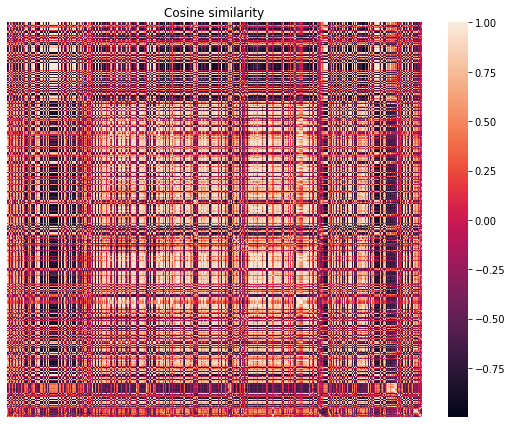

In [16]:
# run permutation function on the reduced feature matrix with acceptability threshold of 0.6
sim_pval_qp = metric_permutation(quantum_props_preprocess['pca']['pca_data'], 'cosine', thr=0.6)

In [18]:
# significant pvalues (alpha = 0.01)
print("pval 0.05:", np.count_nonzero(sim_pval_qp['pvalue'] < 0.05)/2, " pval 0.01:", np.count_nonzero(sim_pval_qp['pvalue'] < 0.01)/2)

pval 0.05: 220025.5  pval 0.01: 89893.5


In [61]:
# check if pvalue matrix is symmetric
check_symmetric(sim_pval_qp['pvalue'])

True

In [19]:
# add similarities to preprocessed object
quantum_props_preprocess['metric'] = {'similarity_matrix' : sim_pval_qp['similarity'], 'pvalue_matrix' : sim_pval_qp['pvalue']}

In [60]:
# construct network and graph of significant similarities
N4, G4 = graph_construction(quantum_props_preprocess['annotation']['samples'], sim_pval_qp, alpha=0.01)

creating network
constructing graph
#nodes:  1743
#edges:  89893


In [41]:
# add network and graph to preprocessed object
quantum_props_preprocess['net'] = {'network' : N4, 'graph' : G4}

In [42]:
# which is the smallest similarity value?
quantum_props_preprocess['net']['network']['Similarity'].min()

0.6000115094300315

In [43]:
# save object 
filename = '../Preprocessed_data/quantum_props.obj'
filehandler = open(filename, 'wb') 
pickle.dump(quantum_props_preprocess, filehandler)

In [44]:
# construct embedding model
G4_model, G4_embeds = graph_embedding(G4, '../Embedding_models/QuantumPropsEmbedding', dim=9)

Computing transition probabilities:   0%|          | 0/1743 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


In [45]:
# similar molecules to 1,1-Dichloroethane
molecules[['CID', 'Chemical_Name', 'Molecular_Formula', 'Canonical_SMILES']][molecules['CID'].isin([(int(x)) for x in list(zip(*G4_model.wv.most_similar('6365', topn=10)))[0]])]

,CID,Chemical_Name,Molecular_Formula,Canonical_SMILES
13,15586,"1,1-dichloro-1-fluoroethane",C2H3Cl2F,CC(F)(Cl)Cl
15,6366,"1,1-dichloroethene",C2H2Cl2,C=C(Cl)Cl
46,24883,"1,3-dichloropropene",C3H4Cl2,C(C=CCl)Cl
327,6344,Dichloromethane,CH2Cl2,C(Cl)Cl
424,6327,Methyl chloride,CH3Cl,CCl
546,10900,"Trans-1,2-dichloroethene",C2H2Cl2,C(=CCl)Cl
1067,31369,Chloroprene,C4H5Cl,C=CC(=C)Cl
1093,7835,Epichlorohydrin,C3H5ClO,C1C(O1)CCl
1151,6573,"1,1-dichloropropane",C3H6Cl2,CCC(Cl)Cl
1370,7931,1-Chloro-3-methylbenzene,C7H7Cl,CC1=CC(=CC=C1)Cl


##### Analyse quantum properties of single elements

In [28]:
# take single elements by CID 
quantum_props_elem = quantum_properties.loc[quantum_properties.index.isin(elem_cid)]
quantum_props_elem.index 

Int64Index([5359268, 5460467, 5462311, 5360770,   24408,     312, 5360523,
              24526,   24524, 3028194,     888, 5462224, 5462309, 6326970,
            5461123,     923, 5360545, 5354495, 5359596, 5355457, 5359367,
              23973, 5460341,   23974, 5354618,   29131,   23976,  104730,
              23978,   23912,   23980,   23981,   23982, 5360835, 6326954,
              23985,   23986,   23988, 5359967,   23924,   23925,   23926,
            5352425,   23929,   23930,   23931,   23932,   23934,     935,
              23936,   23938,   23939,     813, 5462222,   23942,   23948,
            5357696,   23950,   23951,   23952,   23954, 5359327,   23956,
            6327182,   23958, 5359464,   23960, 5352426,   23963,   23964,
              23989,   23990,   23992,   23993,   23994,   23995],
           dtype='int64', name='Molecule_CID')

In [29]:
# run preprocessing
quantum_props_preprocess_elem = data_preprocessing(quantum_props_elem)
quantum_props_preprocess_elem

Pipeline for continuous data
data scaled
number of principal components:  5
Explained variance:  94.0 %


{'annotation': {'samples': Int64Index([5359268, 5460467, 5462311, 5360770,   24408,     312, 5360523,
                24526,   24524, 3028194,     888, 5462224, 5462309, 6326970,
              5461123,     923, 5360545, 5354495, 5359596, 5355457, 5359367,
                23973, 5460341,   23974, 5354618,   29131,   23976,  104730,
                23978,   23912,   23980,   23981,   23982, 5360835, 6326954,
                23985,   23986,   23988, 5359967,   23924,   23925,   23926,
              5352425,   23929,   23930,   23931,   23932,   23934,     935,
                23936,   23938,   23939,     813, 5462222,   23942,   23948,
              5357696,   23950,   23951,   23952,   23954, 5359327,   23956,
              6327182,   23958, 5359464,   23960, 5352426,   23963,   23964,
                23989,   23990,   23992,   23993,   23994,   23995],
             dtype='int64', name='Molecule_CID'),
  'features': Index(['Gas_Phase_Energy', 'Final_Energy', 'HOMO', 'LUMO', 'Polarizabili

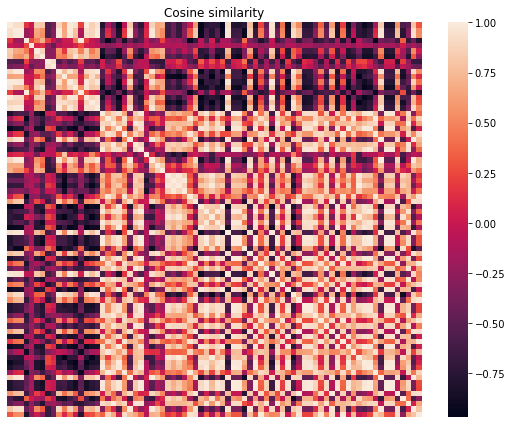

In [30]:
# run permutation function on the reduced feature matrix with acceptability threshold of 0.6
sim_pval_qp_elem = metric_permutation(quantum_props_preprocess_elem['pca']['pca_data'], 'cosine', thr=0.6)

In [31]:
# significant pvalues (alpha = 0.05)
print("pval 0.05:", np.count_nonzero(sim_pval_qp_elem['pvalue'] < 0.05)/2, " pval 0.01:", np.count_nonzero(sim_pval_qp_elem['pvalue'] < 0.01)/2)

pval 0.05: 650.0  pval 0.01: 185.0


In [34]:
# check if pvalue matrix is symmetric
check_symmetric(sim_pval_qp_elem['pvalue'])

True

In [32]:
# add similarities to preprocessed object
quantum_props_preprocess_elem['metric'] = {'similarity_matrix' : sim_pval_qp_elem['similarity'], 'pvalue_matrix' : sim_pval_qp_elem['pvalue']}

In [33]:
# construct network and graph of significant similarities
N4_elem, G4_elem = graph_construction(quantum_props_preprocess_elem['annotation']['samples'], sim_pval_qp_elem, alpha=0.05)

creating network
constructing graph
#nodes:  71
#edges:  650


In [35]:
# add network and graph to preprocessed object
quantum_props_preprocess_elem['net'] = {'network' : N4_elem, 'graph' : G4_elem}

In [36]:
# which is the smallest similarity?
quantum_props_preprocess_elem['net']['network']['Similarity'].min()

0.6000165160933147

In [37]:
# save object 
filename = '../Preprocessed_data/quantum_props_elem.obj'
filehandler = open(filename, 'wb') 
pickle.dump(quantum_props_preprocess_elem, filehandler)

In [38]:
# construct embedding model
G4_elem_model, G4_elem_embeds = graph_embedding(G4_elem, '../Embedding_models/QuantumPropsElemEmbedding', dim=9)

Computing transition probabilities:   0%|          | 0/71 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 87.74it/s]
